---
> **ELGHAZI SOUFIANE**
---

<h2 style='color:olive' align='center'>Text Summarisation (TS) avec TextRank et T5</h2>

<h3 style='color:purple' align='center'>Partie I : Implémenter le modèle de TS T5 afin de résumer le texte.</h3>

* **Importation des bibliothèques :**

In [1]:
from transformers import AutoTokenizer 
from transformers import AutoModelWithLMHead 

* **Choix du texte à résumer:**

In [2]:
content = '''China’s Huawei overtook Samsung Electronics as the world’s biggest seller of mobile phones 
in the second quarter of 2020, shipping 55.8 million devices compared to Samsung’s 53.7 million, 
according to data from research firm Canalys. While Huawei’s sales fell 5 per cent from the same quarter 
a year earlier, South Korea’s Samsung posted a bigger drop of 30 per cent, owing to disruption from the 
coronavirus in key markets such as Brazil, the United States and Europe, Canalys said. Huawei’s overseas 
shipments fell 27 per cent in Q2 from a year earlier, but the company increased its dominance of the 
China market which has been faster to recover from COVID-19 and where it now sells over 70 per cent 
of its phones. “Our business has demonstrated exceptional resilience in these difficult times,” a Huawei 
spokesman said. “Amidst a period of unprecedented global economic slowdown and challenges, we’re 
continued to grow and further our leadership position.” Nevertheless, Huawei’s position as number one 
seller may prove short-lived once other markets recover given it is mainly due to economic disruption, a 
senior Huawei employee with knowledge of the matter told Reuters. Apple is due to release its Q2 
iPhone shipment data on Friday.'''

* **Importation des bibliothèques :Chargement du tokenizer et de l'architecture du modèle:**

In [3]:
tokenizer=AutoTokenizer.from_pretrained('T5-base')
model=AutoModelWithLMHead.from_pretrained('T5-base', return_dict=True)

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1564: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


* **Encodage du texte:**

In [4]:
inputs=tokenizer.encode("sumarize: "+content,return_tensors='pt',max_length=512,truncation=True)

In [5]:
inputs

tensor([[ 4505,   291,  1737,    10,  1473,    22,     7, 18590,   147,   235,
          1825,  5485,  9885,     7,    38,     8,   296,    22,     7,  2630,
          9123,    13,  1156,  7219,    16,     8,   511,  2893,    13,  6503,
             6,  3365,  6897,     5,   927,   770,  1904,     3,  2172,    12,
          5485,    22,     7,   305, 25168,   770,     6,  1315,    12,   331,
            45,   585,  1669, 18565,    63,     7,     5,   818, 18590,    22,
             7,  1085,  4728,   305,   399,  3151,    45,     8,   337,  2893,
             3,     9,   215,  2283,     6,  1013,  7054,    22,     7,  5485,
          1694,     3,     9,  4038,  2328,    13,   604,   399,  3151,     6,
             3, 15942,    12, 17879,    45,     8,  4301,   106,     9, 18095,
            16,   843,  3212,   224,    38,  9278,     6,     8,   907,  1323,
            11,  1740,     6, 18565,    63,     7,   243,     5, 18590,    22,
             7, 10055,     3, 30645,  4728,  2307,  

* **Génération du résumé et décodage :**

In [6]:
output = model.generate(inputs, min_length=80, max_length=100)
summary=tokenizer.decode(output[0])
print(summary)

<pad> Huawei overtook Samsung Electronics as the world’s biggest seller of mobile phones in the second quarter of 2020. shipping 55.8 million devices compared to Samsung’s 53.7 million, according to data from research firm Canalys. while Huawei’s sales fell 5 per cent from the same quarter a year earlier, south Korea’s Samsung posted a bigger drop of 30 per cent owing to disruption from the coronavirus.</s>


In [7]:
print(len(summary))
print(len(content))

410
1252


<h3 style='color:purple' align='center'>Partie II : Implémenter le modèle TextRank afin de résumer le texte.</h3>

* **Importation des bibliothèques :**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import networkx as nx
import re
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import spacy


nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt') # one time execution
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

* **Chargement des données :**

In [9]:
df = pd.read_csv('/kaggle/input/tennis-articles/tennis_articles.csv', encoding='ISO-8859-1')
df.head()

,article_id,article_title,article_text,source
0,1,"I do not have friends in tennis, says Maria Sh...",Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,Federer defeats Medvedev to advance to 14th Sw...,"BASEL, Switzerland (AP)  Roger Federer advanc...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Tennis: Roger Federer ignored deadline set by ...,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Nishikori to face off against Anderson in Vien...,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,Roger Federer has made this huge change to ten...,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [10]:
df.columns

Index(['article_id', 'article_title', 'article_text', 'source'], dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     8 non-null      int64 
 1   article_title  8 non-null      object
 2   article_text   8 non-null      object
 3   source         8 non-null      object
dtypes: int64(1), object(3)
memory usage: 384.0+ bytes


In [12]:
df.shape

(8, 4)

* **Prétraitement des données:**

In [13]:
def preprocess_text(text):
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words("english")) 
    # Tokenize and remove stopwords
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence) if word.isalnum() and word.lower() not in stop_words]  
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]    
    return sentences, words
sentences, words = preprocess_text(df["article_text"][0])

* **Encodage du texte:**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fonction pour calculer la matrice de similarité entre les phrases
def calculate_sentence_similarity(sentences):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    similarity_matrix = np.dot(tfidf_matrix, tfidf_matrix.T)
    return similarity_matrix

In [15]:
def build_graph(words, sentences):
    G = nx.Graph()   
    for i, sentence1 in enumerate(sentences):
        for j, sentence2 in enumerate(sentences):
            if i != j:
                # Calculate Jaccard similarity between sentences based on words
                words1 = set(words[i])
                words2 = set(words[j])
                similarity = len(words1.intersection(words2)) / len(words1.union(words2))            
                # Add an edge to the graph with the similarity score as the weight
                G.add_edge(i, j, weight=similarity)
    return G
graph = build_graph(words, sentences)

In [16]:
def calculate_scores(graph):
    scores = nx.pagerank(graph, weight='weight')
    return scores
scores = calculate_scores(graph)

In [17]:
pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [21]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

def extract_top_sentences_with_scores(scores, sentences, n=9):
    ranked_sentences = sorted(((scores[i], sentence) for i, sentence in enumerate(sentences)), reverse=True)
    top_sentences_with_scores = [(score, sentence) for score, sentence in ranked_sentences[:n]]
    return top_sentences_with_scores

* **Construction du modèle TextRank :**

In [23]:
def build_graph_with_visualization(words, sentences):
    G = nx.Graph()

    for i, sentence1 in enumerate(sentences):
        for j, sentence2 in enumerate(sentences):
            if i != j:
                words1 = set(words[i])
                words2 = set(words[j])
                similarity = len(words1.intersection(words2)) / len(words1.union(words2))
                G.add_edge(i, j, weight=similarity)

    # Visualization: Add edges with weights as labels
    edge_labels = {(i, j): f'{weight:.2f}' for i, j, weight in G.edges(data='weight')}
    
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

    return G

In [24]:
def summerizer_with_scores(text):
    sentences, words = preprocess_text(text)

    # Build the graph with visualization
    graph = build_graph_with_visualization(words, sentences)

    # Calculate scores and extract the top sentences with scores for summary
    scores = calculate_scores(graph)
    top_sentences_with_scores = extract_top_sentences_with_scores(scores, sentences)

    # Display the summary with scores
    summary = ' '.join(sentence for score, sentence in top_sentences_with_scores)
    print("Original Text:\n", text)
    print("\nSummary:\n", summary)

    # Convert references to a list of sentences
    reference = sent_tokenize(text)
    reference = [' '.join(word_tokenize(sentence)) for sentence in reference]

    # Convert the candidate (summary) to a string
    candidate = ' '.join(word_tokenize(summary))

    # BLEU Score
    bleu_score = sentence_bleu(reference, candidate)

    # ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(' '.join(reference), candidate)
    rouge_n_score = rouge_scores['rouge1'].precision
    rouge_l_score = rouge_scores['rougeL'].precision

    print("\nBLEU Score:", bleu_score)
    print("ROUGE-N Score:", rouge_n_score)
    print("ROUGE-L Score:", rouge_l_score)

* **Génération du résumé et graphe et Voir le rouge et bleu score :**

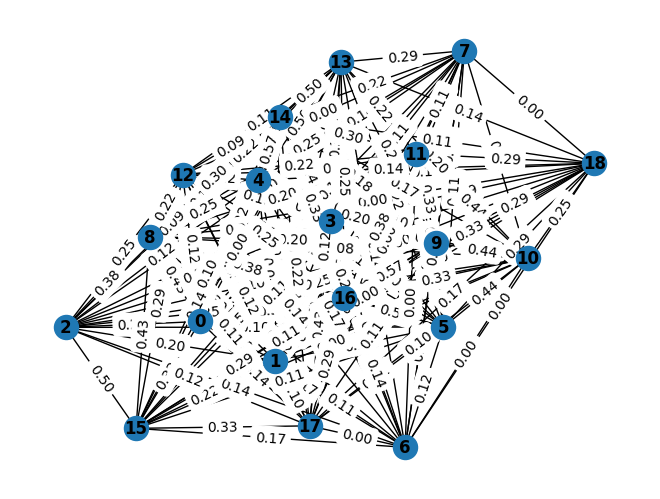

Original Text:
 Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net. So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you

In [25]:
summerizer_with_scores(df.article_text[0])

Articel 1 :


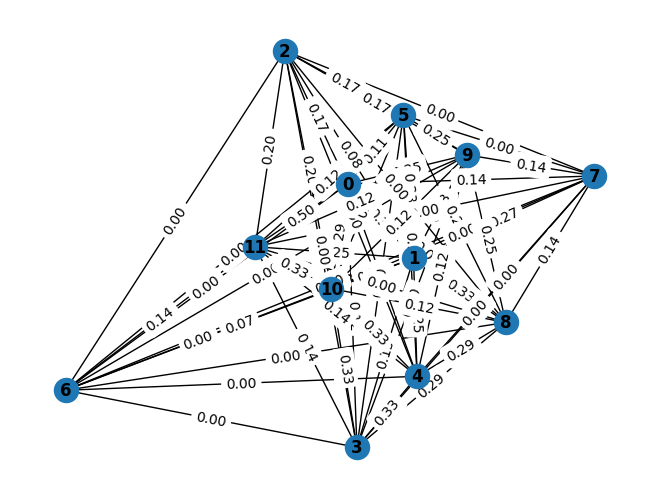

Original Text:
 BASEL, Switzerland (AP)  Roger Federer advanced to the 14th Swiss Indoors final of his career by beating seventh-seeded Daniil Medvedev 6-1, 6-4 on Saturday. Seeking a ninth title at his hometown event, and a 99th overall, Federer will play 93th-ranked Marius Copil on Sunday. Federer dominated the 20th-ranked Medvedev and had his first match-point chance to break serve again at 5-1. He then dropped his serve to love, and let another match point slip in Medvedev's next service game by netting a backhand. He clinched on his fourth chance when Medvedev netted from the baseline. Copil upset expectations of a Federer final against Alexander Zverev in a 6-3, 6-7 (6), 6-4 win over the fifth-ranked German in the earlier semifinal. The Romanian aims for a first title after arriving at Basel without a career win over a top-10 opponent. Copil has two after also beating No. 6 Marin Cilic in the second round. Copil fired 26 aces past Zverev and never dropped serve, clinching after 

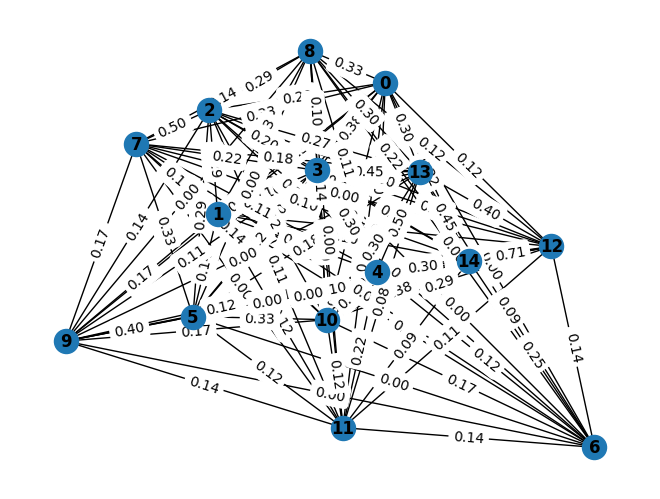

Original Text:
 Roger Federer has revealed that organisers of the re-launched and condensed Davis Cup gave him three days to decide if he would commit to the controversial competition. Speaking at the Swiss Indoors tournament where he will play in Sundays final against Romanian qualifier Marius Copil, the world number three said that given the impossibly short time frame to make a decision, he opted out of any commitment. They only left me three days to decide, Federer said. I didnt to have time to consult with all the people I had to consult. I could not make a decision in that time, so I told them to do what they wanted. The 20-time Grand Slam champion has voiced doubts about the wisdom of the one-week format to be introduced by organisers Kosmos, who have promised the International Tennis Federation up to $3 billion in prize money over the next quarter-century. The competition is set to feature 18 countries in the November 18-24 finals in Madrid next year, and will replace th

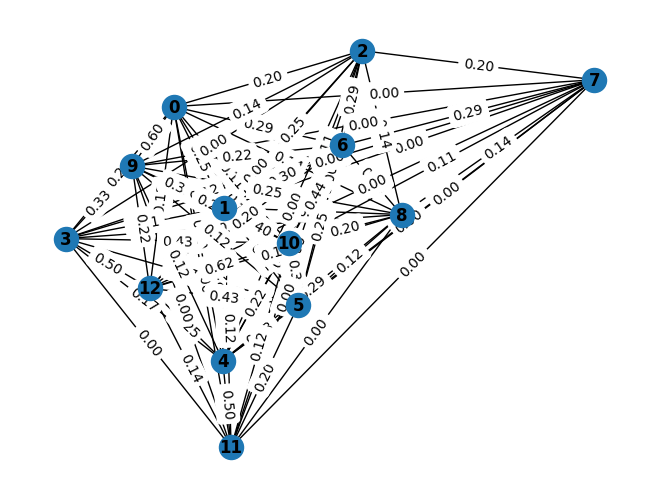

Original Text:
 Kei Nishikori will try to end his long losing streak in ATP finals and Kevin Anderson will go for his second title of the year at the Erste Bank Open on Sunday. The fifth-seeded Nishikori reached his third final of 2018 after beating Mikhail Kukushkin of Kazakhstan 6-4, 6-3 in the semifinals. A winner of 11 ATP events, Nishikori hasn't triumphed since winning in Memphis in February 2016. He has lost eight straight finals since. The second-seeded Anderson defeated Fernando Verdasco 6-3, 3-6, 6-4. Anderson has a shot at a fifth career title and second of the year after winning in New York in February. Nishikori leads Anderson 4-2 on career matchups, but the South African won their only previous meeting this year. With a victory on Sunday, Anderson will qualify for the ATP Finals. Currently in ninth place, Nishikori with a win could move to within 125 points of the cut for the eight-man event in London next month. Nishikori held serve throughout against Kukushkin, who came

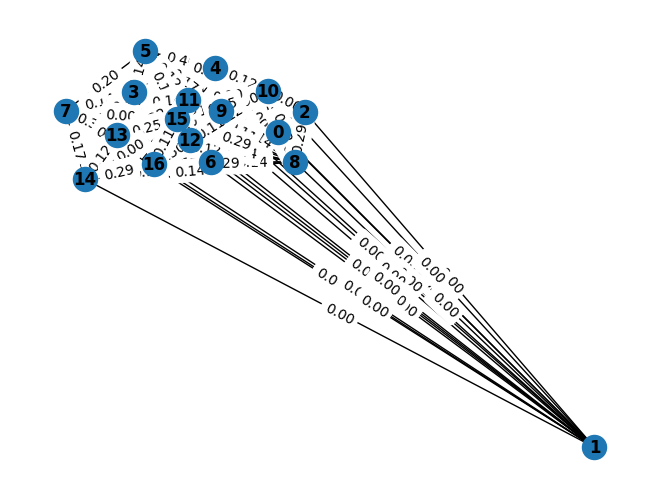

Original Text:
 Federer, 37, first broke through on tour over two decades ago and he has since gone on to enjoy a glittering career. The 20-time Grand Slam winner is chasing his 99th ATP title at the Swiss Indoors this week and he faces Jan-Lennard Struff in the second round on Thursday (6pm BST). Davenport enjoyed most of her success in the late 1990s and her third and final major tournament win came at the 2000 Australian Open. But she claims the mentality of professional tennis players slowly began to change after the new millennium. It seems pretty friendly right now, said Davenport. I think there is a really nice environment and a great atmosphere, especially between some of the veteran players helping some of the younger players out. It's a very pleasant atmosphere, I'd have to say, around the locker rooms. I felt like the best weeks that I had to get to know players when I was playing were the Fed Cup weeks or the Olympic weeks, not necessarily during the tournaments. And 

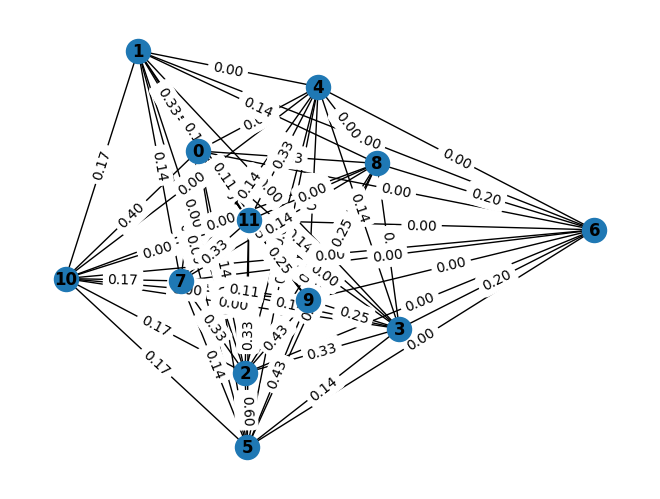

Original Text:
 Nadal has not played tennis since he was forced to retire from the US Open semi-finals against Juan Martin Del Porto with a knee injury. The world No 1 has been forced to miss Spains Davis Cup clash with France and the Asian hard court season. But with the ATP World Tour Finals due to begin next month, Nadal is ready to prove his fitness before the season-ending event at the 02 Arena. Nadal flew to Paris on Friday and footage from the Paris Masters official Twitter account shows the Spaniard smiling as he strides onto court for practice. The Paris Masters draw has been made and Nadal will start his campaign on Tuesday or Wednesday against either Fernando Verdasco or Jeremy Chardy. Nadal could then play defending champion Jack Sock in the third round before a potential quarter-final with either Borna Coric or Dominic Thiem. Nadals appearance in Paris is a big boost to the tournament organisers who could see Roger Federer withdraw. Federer is in action at the Swiss Indo

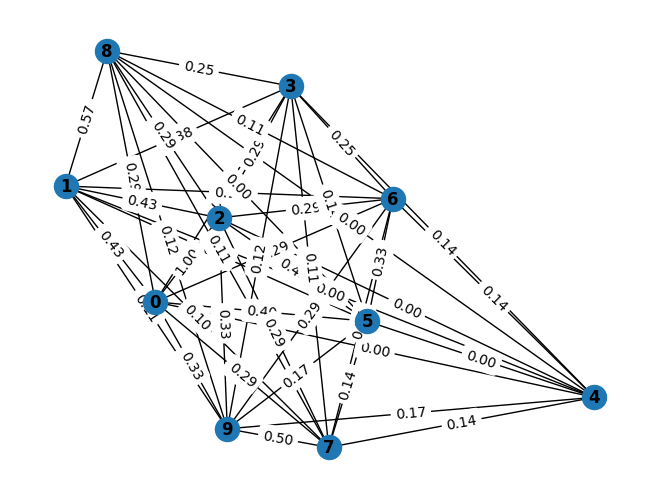

Original Text:
 Tennis giveth, and tennis taketh away. The end of the season is finally in sight, and with so many players defendingor losinghuge chunks of points in Singapore, Zhuhai and London, podcast co-hosts Nina Pantic and Irina Falconi discuss the art of defending points (02:14). It's no secret that Jack Sock has struggled on the singles court this year (his record is 7-19). He could lose 1,400 points in the next few weeksbut instead of focusing on the negative, it can all be about perspective (06:28). Let's also not forget his two Grand Slam doubles triumphs this season. Two players, Stefanos Tsitsipas and Kyle Edmund, won their first career ATP titles last week (13:26). It's a big deal because...you never forget your first. Irina looks back at her WTA title win in Bogota in 2016, and tells an unforgettable story about her semifinal drama (14:04). In Singapore, one of the biggest storylines (aside from the matches, of course) has been the on-court coaching debate. Nina and I

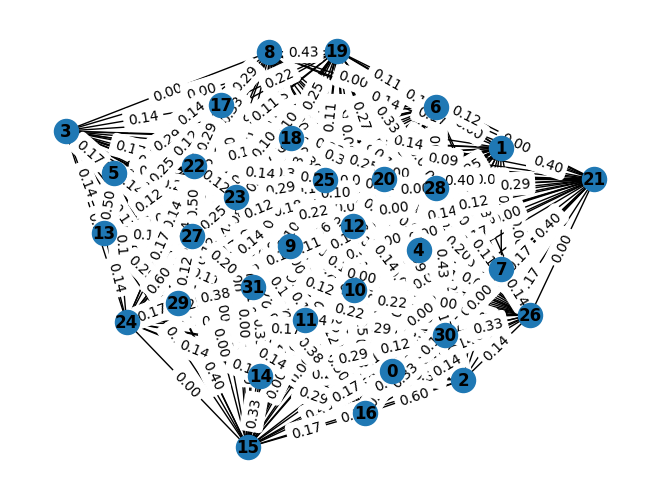

Original Text:
 I PLAYED golf last week with Todd Reid. He picked me up at 5.30am, half an hour early because he couldnt sleep. Or hadnt slept, to be specific. Not because hed been out on a bender or anything  those days were in the past. The former Wimbledon junior champion was full of hope, excited about getting his life back together after a troubled few years and a touch-and-go battle with pancreatitis. Im pleased with that, he said after grinding out an eight-over-par front nine at the not-so-royal Northbridge club in Sydney and smashing down an egg- and-bacon roll at the halfway house. To most players of his rare sporting gifts, such a modest return would be unacceptable. To Reid the 15-marker, just being up and at em was enough; a few bogeys and one well-made par  broomstick putter and all  vindication for his recent decision to renew his membership at nearby Bankstown. Exhausted after spending half his round deep in the bushes searching for my ball, as well as those o

In [26]:
for i in range(1,8):
    print(f"Articel {i} :")
    summerizer_with_scores(df.article_text[i])
    print("\t\t\t\t-----------------------------------------------------------------------------------------------\n")

<h2 style='color:olive' align='center'>Fin</h2>